In [29]:
import pandas as pd
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
df_fraud = pd.read_csv("PS_20174392719_1491204439457_log.csv")
df_fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df_fraud.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
encodingData = LabelEncoder()
df_fraud['type'] = encodingData.fit_transform(df_fraud['type'])

In [5]:
df_fraud = df_fraud.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])
df_fraud.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1
3,1,1,181.00,181.0,0.00,21182.0,0.0,1
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

In [7]:
xdata = df_fraud.drop(columns=['isFraud'])
ydata = df_fraud['isFraud']

In [8]:
scalerData = StandardScaler()
xdata_scaled = scalerData.fit_transform(xdata)

In [9]:
X_trainData, X_testData, y_trainData, y_testData = train_test_split(xdata_scaled, ydata, test_size=0.3, random_state=42)

In [10]:
neural_model = Sequential()
neural_model.add(Dense(64, input_dim=X_trainData.shape[1], activation='relu'))  
neural_model.add(Dense(32, activation='relu'))                            
neural_model.add(Dense(1, activation='sigmoid'))

In [12]:
neural_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
neural_model.fit(X_trainData, y_trainData, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/5
111346/111346 [==============================] - 583s 5ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0024 - val_accuracy: 0.9995
Epoch 2/5
111346/111346 [==============================] - 677s 6ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0024 - val_accuracy: 0.9995
Epoch 3/5
111346/111346 [==============================] - 895s 8ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0025 - val_accuracy: 0.9995
Epoch 4/5
111346/111346 [==============================] - 893s 8ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0023 - val_accuracy: 0.9995
Epoch 5/5
111346/111346 [==============================] - 731s 7ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0024 - val_accuracy: 0.9995


In [13]:
loss_data, accuracy_value = neural_model.evaluate(X_testData, y_testData)
print(f"Test Loss: {loss_data:.4f}, Test Accuracy: {accuracy_value:.4f}")

59650/59650 [==============================] - 285s 5ms/step - loss: 0.0023 - accuracy: 0.9995
Test Loss: 0.0023, Test Accuracy: 0.9995


In [14]:
neural_y_pred_prob = neural_model.predict(X_testData)
neural_y_pred = (neural_y_pred_prob > 0.5).astype("int32")

59650/59650 [==============================] - 267s 4ms/step


In [17]:
print(classification_report(y_testData, neural_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.91      0.66      0.77      2435

    accuracy                           1.00   1908786
   macro avg       0.96      0.83      0.88   1908786
weighted avg       1.00      1.00      1.00   1908786



In [19]:
neural_cm = confusion_matrix(y_testData, neural_y_pred)
print("Confusion Matrix of Neural Network Model:")
print(neural_cm)

Confusion Matrix of Neural Network Model:
[[1906197     154]
 [    820    1615]]


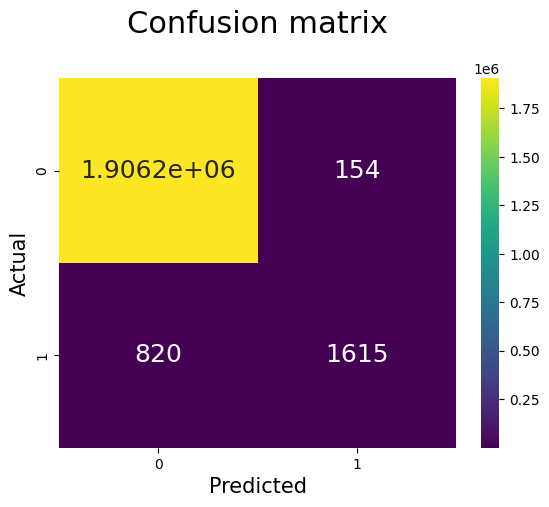

In [35]:
sns.heatmap(pd.DataFrame(neural_cm), annot=True, annot_kws={"size": 18}, cmap="viridis" ,fmt='g')
plt.title('Confusion matrix', y=1.1, fontsize = 22)
plt.ylabel('Actual',fontsize = 15)
plt.xlabel('Predicted',fontsize = 15)
plt.show()

In [21]:
neural_auc_score = roc_auc_score(y_testData, neural_y_pred_prob) 
print(f"AUC-ROC Score: {neural_auc_score:.4f}")

AUC-ROC Score: 0.9947


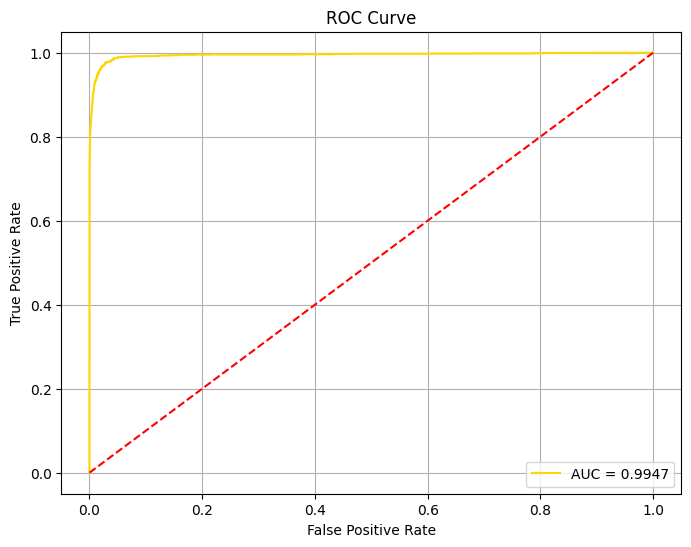

In [36]:
fpr, tpr, thresholds = roc_curve(y_testData, neural_y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='gold', label=f'AUC = {neural_auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [38]:
df_conf_matrix = pd.DataFrame(
    neural_cm,
    columns=["Predicted_NotFraud", "Predicted_Fraud"],
    index=["Actual_NotFraud", "Actual_Fraud"]
)
df_conf_matrix.to_csv("confusion_matrix_df_Fraud.csv")

In [ ]:
precisionData, recallData, Valuethresholds = precision_recall_curve(y_testData, neural_y_pred_prob)
df_Fraud_Factors = pd.DataFrame({
    "Thresholds": np.append(Valuethresholds, 1),
    "Recall": recallData,
    "Precision": precisionData
})
df_Fraud_Factors.to_csv("df_Fraud_precision_recall.csv", index=False)